## <center> STA160 Final Exam

## <center> Time Series Analysis of Wind Speed Data for Year 2003
    
## <center> 03 June 2022

## 1. Introduction

Time series analysis is a type of data analysis where the set of data points is taken at a specified time or usually at equal intervals. We use the analysis to predict future unobserved values based on the observed data values. It uses just one variable "time" to extract meaningful statistics and other important characteristics. Also, it is applicable to perform business forecasting, understand/analyze past behavior, plan for future events, and evaluate current accomplishments.

The goal of this project is to compare the climate change pattern in the six counties from the years 2006 to 2007 and 2003. However, due to a lot of missing observations for the years 2006 and 2007, the focus of the analysis will only be on the year 2003.
 
The research question is to check whether assumptions are met to fit the right model that predicts the monthly wind speed rate in the counties. The procedure is to first check whether the time-series data are stationary. This means the data should have a constant mean, constant variance, and an auto-covariance that should not depend on time. In addition, the transformation of data can be applied to remove noise and meet the stationarity assumption. This follows by computing the sample autocorrelation and partial-correlation (pacf). Finally, we fit the model and select the optimal model based on the selection criterion of Ljung-Box statistic that contains the smallest AIC value.

## 2. Data Analysis by Counties for the year '2003'

In [1]:
#Import Libraries

#needed to make web requests
import requests

#store the data we get as a dataframe
import pandas as pd

#convert the response as a strcuctured json
import json

#mathematical operations on lists
import numpy as np

#parse the datetimes we get from NOAA
from datetime import datetime

import io

import itertools
from itertools import repeat

import matplotlib.pylab as plt
%matplotlib inline

import seaborn as sns 

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6

## <center> 1. El Dorado County

In [2]:
eldorado = pd.read_csv("/Users/selamawit/Desktop/STA160/Final/data/wind_data/el_dorado_county_wind_data.csv")
print(eldorado.tail())

            Date  wind_speed
1450  2010-12-24         1.6
1451  2010-12-25        13.9
1452  2010-12-26         9.8
1453  2010-12-27         2.9
1454  2010-12-28        10.1


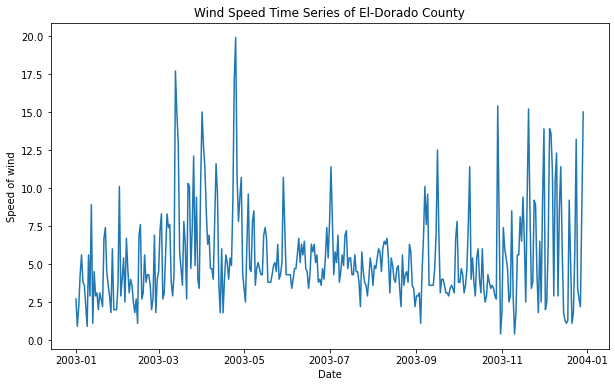

In [3]:
#Parse strings to datetime type
eldorado['Date'] = pd.to_datetime(eldorado['Date'], format='%Y-%m-%d')
eldorado.index = eldorado['Date']
del eldorado['Date']
eld03 = eldorado[eldorado.index < "2003-12-30"]
# print(eld03)

#Test (1) to check stationarity of data == Plot graph
plt.xlabel("Date")
plt.ylabel("Speed of wind")
plt.title("Wind Speed Time Series of El-Dorado County")
plt.plot(eld03)

Initial step of data analysis is to perform exploratory approach to understand the data. This helps us to determine whether the time series assumption are hold.

Stationary is a very important property that determines if the mean, variance, and autocorrelation of the time variable are constant over time. This does not mean that the values for each data point have to be the same, but the overall behavior of the data should remain constant. This helps to apply right models to forecast future behaviors. 

In this above plot, we observe the behavior did not remain constant and thus stationarity does not hold.

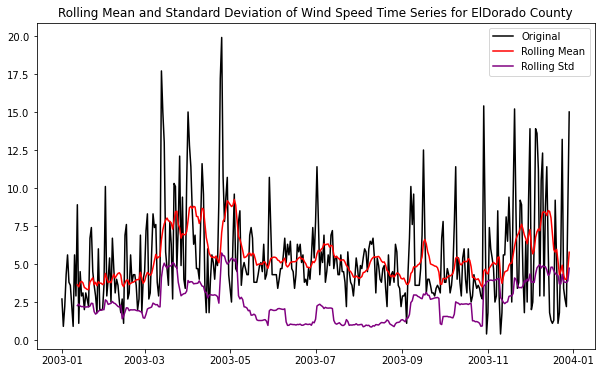

In [4]:
#Test (2) to check stationarity of data == statistics of data
#(1) Determining rolling statistics in annual level
rolmean = eld03.rolling(window=12).mean()
rolstd = eld03.rolling(window=12).std()
# print(rolmean, rolstd)

# Plot 
orig = plt.plot(eld03, color='black', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='purple', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation of Wind Speed Time Series for ElDorado County')
plt.show(block=False)

In [5]:
#(2) Perform Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

print('Result of Dickey-Fuller test')

#Akaike information criterion (AIC) 
dftest = adfuller(eld03["wind_speed"], autolag='AIC')
# print(dftest)
dfoutput = pd.Series(dftest[0:4], 
                     index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key]=value
print(dfoutput)

Result of Dickey-Fuller test
Test Statistic               -6.227550e+00
p-value                       5.045358e-08
#Lags Used                    4.000000e+00
Number of Observation Used    3.580000e+02
Critical Value (1%)          -3.448749e+00
Critical Value (5%)          -2.869647e+00
Critical Value (10%)         -2.571089e+00
dtype: float64


Augmented Dickey-fuller test is a statistical significance test applied for time series data to compute test statistic, critical value and p-value to infer about the given set of data. This method provides negative number to help determine the result of the hypothesis test. An auto-lag calculates the correlation between values that are one time period apart. In this case, we have a lag of 12 month time period apart.  The auto-lag function uses AIC estimator of predicting error and 
finding good quality of statistical models for a given set of data. It selects AIC with lower values as a better-fit.

Hypothesis Test:

Ho = Given data is not stationary

Ha = Given data is stationary


The statistical result indicates the data is not stationary because test statistic (-6.22e+00) is less than critical value (-2.86e+00) at 5% significance level.

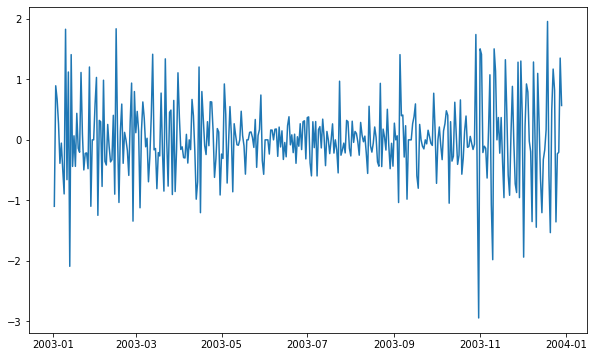

In [6]:
#Transformation
#Estimate of trend
eld03_logScale = np.log(eld03) #y values are changed
# plt.plot(imp03_logScale) #only little improvement

#Shift values to time series for forecasting y
datasetLogDiffShifting = eld03_logScale - eld03_logScale.shift()
plt.plot(datasetLogDiffShifting) #good improvement

good improvement!

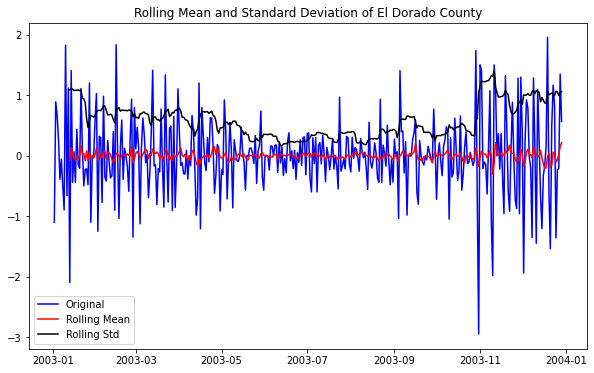

Result of Dickey-Fuller Test:
Test Statistic               -7.711616e+00
p-value                       1.259459e-11
#Lags Used                    1.700000e+01
Number of Observation Used    3.440000e+02
Critical Value (1%)          -3.449503e+00
Critical Value (5%)          -2.869979e+00
Critical Value (10%)         -2.571266e+00
dtype: float64


In [7]:
def test_stationarity(timeseries):
    #Determining rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation of El Dorado County')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Result of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['wind_speed'], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting) #shift by one

still we fail to reject test stat is less than critical

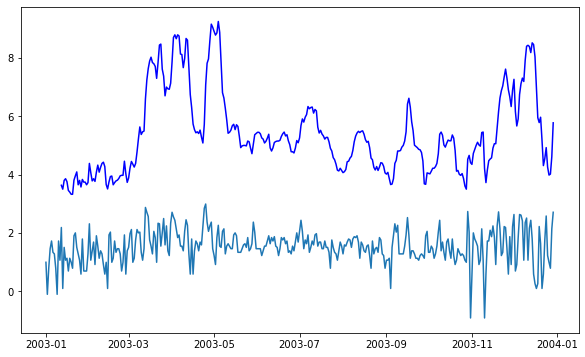

In [8]:
movingAverage = eld03.rolling(window=12).mean()
movingSTD = eld03.rolling(window=12).std()
plt.plot(eld03_logScale)
plt.plot(movingAverage, color='blue')

not at all statinary!

In [9]:
#Take difference 
datasetLogScaleMinusMovingAverage = eld03_logScale-movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove Nan Values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,wind_speed
Date,
2003-01-12,-1.447282
2003-01-13,-3.404690
2003-01-14,-2.295923
2003-01-15,-2.793623
2003-01-16,-2.626931
2003-01-17,-2.765186
2003-01-18,-2.268598
2003-01-19,-2.331748
2003-01-20,-2.536543


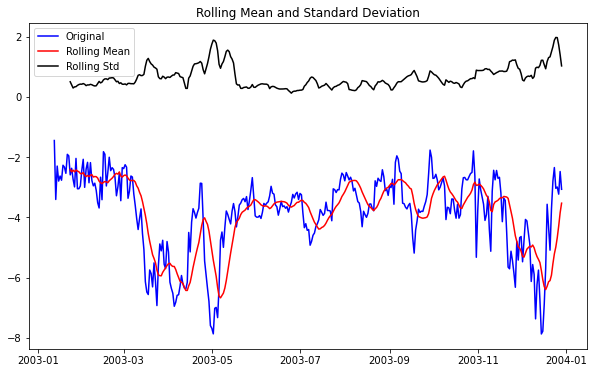

Result of Dickey-Fuller Test:
Test Statistic                 -2.274518
p-value                         0.180318
#Lags Used                     13.000000
Number of Observation Used    338.000000
Critical Value (1%)            -3.449846
Critical Value (5%)            -2.870129
Critical Value (10%)           -2.571346
dtype: float64


In [10]:
def test_stationarity(timeseries):
    #Determining rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Result of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['wind_speed'], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(datasetLogScaleMinusMovingAverage)

not stattionary!

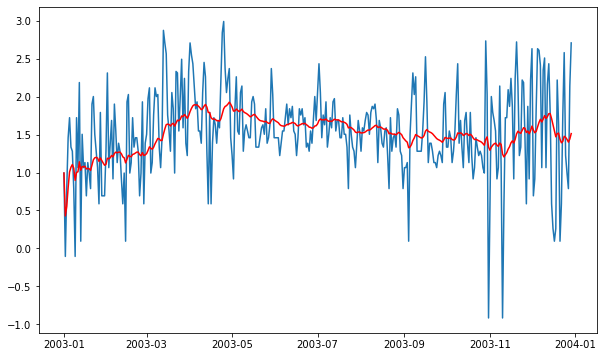

In [11]:
exponentialDecayWeightedAverage = eld03_logScale.ewm(halflife=12,min_periods=0,adjust=True).mean()
plt.plot(eld03_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

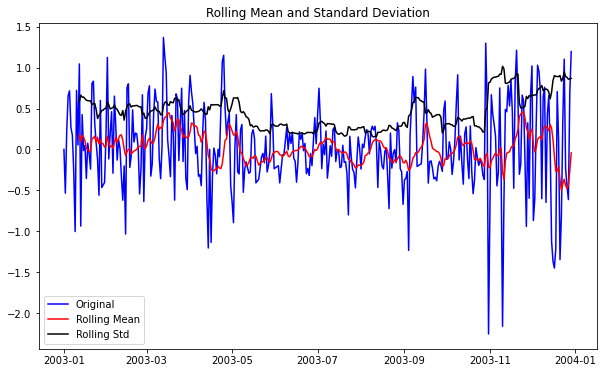

Result of Dickey-Fuller Test:
Test Statistic               -6.124028e+00
p-value                       8.716239e-08
#Lags Used                    8.000000e+00
Number of Observation Used    3.540000e+02
Critical Value (1%)          -3.448958e+00
Critical Value (5%)          -2.869739e+00
Critical Value (10%)         -2.571138e+00
dtype: float64


In [12]:
#Another Transformation
datasetScaleMinusMovingExponentialDecayAverage = eld03_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetScaleMinusMovingExponentialDecayAverage)

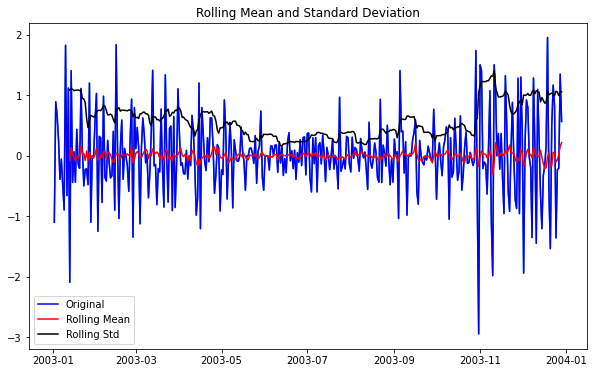

Result of Dickey-Fuller Test:
Test Statistic               -7.711616e+00
p-value                       1.259459e-11
#Lags Used                    1.700000e+01
Number of Observation Used    3.440000e+02
Critical Value (1%)          -3.449503e+00
Critical Value (5%)          -2.869979e+00
Critical Value (10%)         -2.571266e+00
dtype: float64


In [13]:
#Shift values to time series for forecasting y
datasetLogDiffShifting = eld03_logScale - eld03_logScale.shift()
plt.plot(datasetLogDiffShifting)
plt.title("Rolling Mean and Standard Deviation of Transformed Time Series for El Dorado County")

datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting) #shift by one


finally test statistics is greater than critical value. it means data is stationary at 5% level

## <center> 2. Imperial County

In [14]:
imperial = pd.read_csv("/Users/selamawit/Desktop/STA160/Final/data/wind_data/Imperial_county_wind_data.csv")
print(imperial.head())

         Date  wind_speed
0  2003-01-01         5.6
1  2003-01-02         5.6
2  2003-01-03         3.8
3  2003-01-03         3.1
4  2003-01-04         3.1


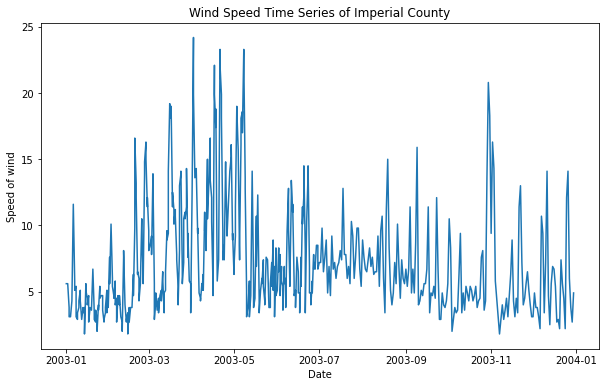

In [15]:
#Parse strings to datetime type
imperial['Date'] = pd.to_datetime(imperial['Date'], format='%Y-%m-%d')
imperial.index = imperial['Date']
del imperial['Date']
imp03 = imperial[imperial.index < "2003-12-31"]
# print(imp03)

#plot
plt.xlabel("Date")
plt.ylabel("Speed of wind")
plt.title("Wind Speed Time Series of Imperial County")
plt.plot(imp03)

does not look stationary!

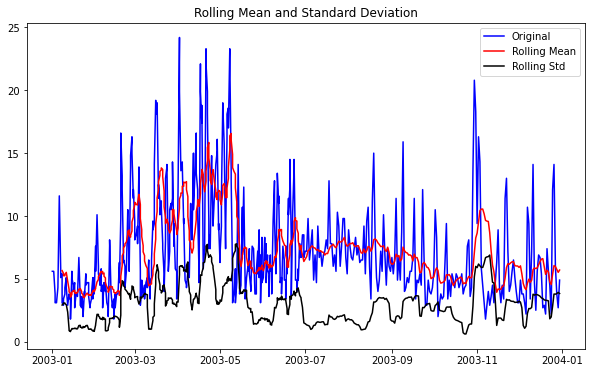

In [16]:
#Test stationarity of data:
#(1) Determining rolling statistics in annual level
rolmean = imp03.rolling(window=12).mean() #mean yearly level
rolstd = imp03.rolling(window=12).std()
# print(rolmean, rolstd)

#Plot rolling statistics
orig = plt.plot(imp03, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show(block=False)

In [17]:
#(2) Perform Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

print('Result of Dickey-Fuller test')
#AIC means and in time series
dftest = adfuller(imp03["wind_speed"], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key]=value
print(dfoutput)

Result of Dickey-Fuller test
Test Statistic                 -4.907685
p-value                         0.000034
#Lags Used                      6.000000
Number of Observation Used    507.000000
Critical Value (1%)            -3.443314
Critical Value (5%)            -2.867258
Critical Value (10%)           -2.569815
dtype: float64


we fail to reject null at 5% significane level because test statistic(-4.9) is less than crtical value(-2.867)

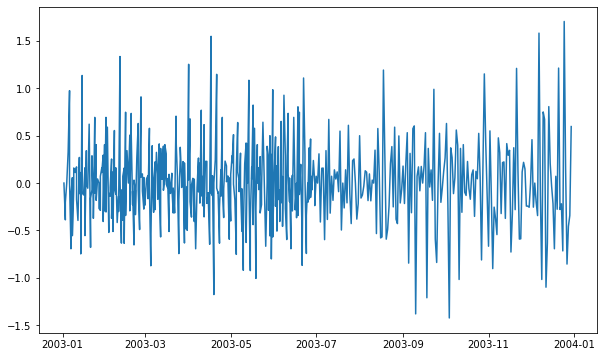

In [18]:
#Transformation
#Estimate of trend
imp03_logScale = np.log(imp03) #y values are changed
# plt.plot(imp03_logScale) #only little improvement

#Shift values to time series for forecasting y
datasetLogDiffShifting = imp03_logScale - imp03_logScale.shift()
plt.plot(datasetLogDiffShifting) #good improvement

we see improvement!

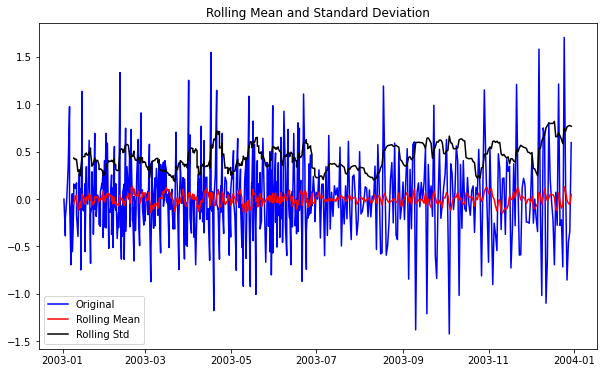

Result of Dickey-Fuller Test:
Test Statistic               -1.037978e+01
p-value                       2.154155e-18
#Lags Used                    1.300000e+01
Number of Observation Used    4.990000e+02
Critical Value (1%)          -3.443523e+00
Critical Value (5%)          -2.867350e+00
Critical Value (10%)         -2.569864e+00
dtype: float64


In [19]:
def test_stationarity(timeseries):
    #Determining rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Result of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['wind_speed'], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting) #shift by one

Ho: Given Data is not stationary vs 
Ha: Given Data is stationary

Since test statistic (-1.03e+01) is greater than critical value (-2.86e+00), we reject the null hypothesis at 5% significance level and conclude that data is stationary. We observe mean and variance is going constant with time.
Not a stationary data because both mean and variance are not constant.

## <center> 3. Mendocino County

In [20]:
mendocino = pd.read_csv("/Users/selamawit/Desktop/STA160/Final/data/wind_data/Mendocino_county_wind_data.csv")
print(mendocino.head())

         Date  wind_speed
0  2003-01-01         0.7
1  2003-01-02         0.9
2  2003-01-03         0.7
3  2003-01-04         0.9
4  2003-01-05         2.2


In [21]:
#Parse strings to datetime type
mendocino['Date'] = pd.to_datetime(mendocino['Date'], format='%Y-%m-%d')
mendocino.index = mendocino['Date']
del mendocino['Date']

men03 = mendocino[mendocino.index < "2003-12-30"]
print(men03)

            wind_speed
Date                  
2003-01-01         0.7
2003-01-02         0.9
2003-01-03         0.7
2003-01-04         0.9
2003-01-05         2.2
...                ...
2003-12-25         4.7
2003-12-26         0.4
2003-12-27         0.0
2003-12-28         3.4
2003-12-29         5.1

[363 rows x 1 columns]


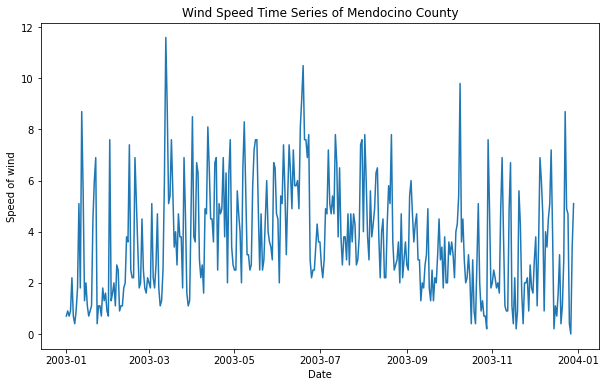

In [22]:
#plot
plt.xlabel("Date")
plt.ylabel("Speed of wind")
plt.title("Wind Speed Time Series of Mendocino County")
plt.plot(men03)

needs some improvement!

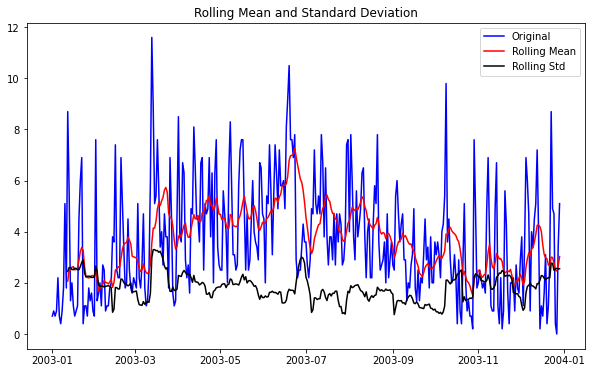

In [23]:
#Test stationarity of data:
#(1) Determining rolling statistics in annual level
rolmean = men03.rolling(window=12).mean() #mean yearly level
rolstd = men03.rolling(window=12).std()
# print(rolmean, rolstd)

#Plot rolling statistics
orig = plt.plot(men03, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show(block=False)


In [24]:
#(2) Perform Dickey-Fuller test
print('Result of Dickey-Fuller test')
#AIC means and in time series
dftest = adfuller(men03["wind_speed"], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key]=value
print(dfoutput)


Result of Dickey-Fuller test
Test Statistic               -5.980645e+00
p-value                       1.842046e-07
#Lags Used                    4.000000e+00
Number of Observation Used    3.580000e+02
Critical Value (1%)          -3.448749e+00
Critical Value (5%)          -2.869647e+00
Critical Value (10%)         -2.571089e+00
dtype: float64


not stationary test stat is less than critical
also plot shows variance isnot constant with time.

Text(0.5, 1.0, 'Wind Speed Time Series of Mendocino County')

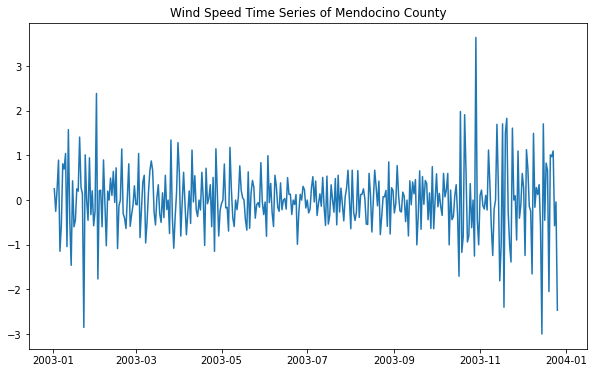

In [25]:
#Transformation
#Estimate of trend
men03_logScale = np.log(men03) #y values are changed
# plt.plot(men03_logScale) #bad

#Shift values to time series for forecasting y
datasetLogDiffShifting = men03_logScale - men03_logScale.shift()
# print(datasetLogDiffShifting) #return NAN values and -inf

#Remove Nan Values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

plt.plot(datasetLogDiffShifting) #good improvement
plt.title("Wind Speed Time Series of Mendocino County")

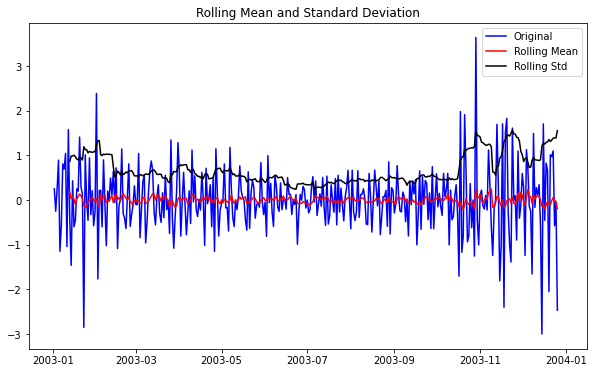

In [26]:
def test_stationarity(timeseries):
    #Determining rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
#     print('Result of Dickey-Fuller Test:')
#     dftest = adfuller(timeseries['wind_speed'], autolag='AIC')
#     dfoutput=pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation Used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print(dfoutput)
    
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting) #shift by one

we see improvement but result for statistical significant have code error!!!!

## <center> 4. Riverside County

In [27]:
riverside = pd.read_csv("/Users/selamawit/Desktop/STA160/Final/data/wind_data/Riverside_county_wind_data.csv")
print(riverside.head())

         Date  wind_speed
0  2003-01-01         6.9
1  2003-01-01        10.1
2  2003-01-01        12.1
3  2003-01-01         6.7
4  2003-01-02         3.6


In [28]:
#Parse strings to datetime type
riverside['Date'] = pd.to_datetime(riverside['Date'], format='%Y-%m-%d')
riverside.index = riverside['Date']
del riverside['Date']

river03 = riverside[riverside.index < "2003-12-30"]
print(river03)

            wind_speed
Date                  
2003-01-01         6.9
2003-01-01        10.1
2003-01-01        12.1
2003-01-01         6.7
2003-01-02         3.6
...                ...
2003-09-06         5.1
2003-09-07         6.5
2003-09-07         4.0
2003-09-07         9.6
2003-09-07         6.7

[1000 rows x 1 columns]


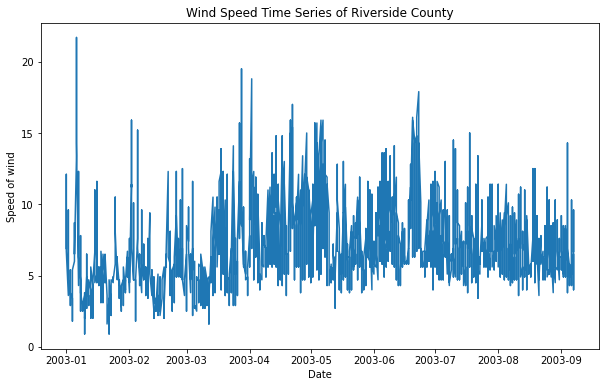

In [29]:
#plot
plt.xlabel("Date")
plt.ylabel("Speed of wind")
plt.title("Wind Speed Time Series of Riverside County")
plt.plot(river03)

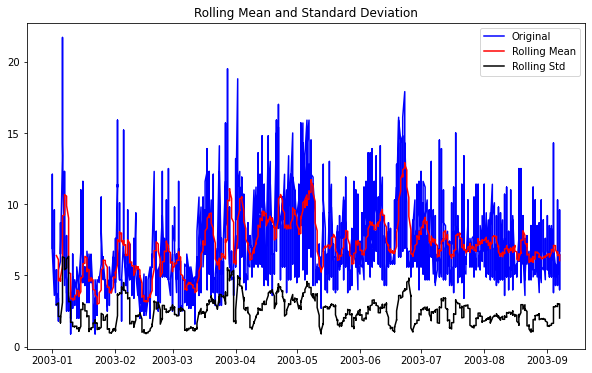

In [30]:
#Test stationarity of data:
#(1) Determining rolling statistics in annual level
rolmean = river03.rolling(window=12).mean() #mean yearly level
rolstd = river03.rolling(window=12).std()
# print(rolmean, rolstd)

#Plot rolling statistics
orig = plt.plot(river03, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show(block=False)


In [31]:
#(2) Perform Dickey-Fuller test
print('Result of Dickey-Fuller test')
#AIC means and in time series
dftest = adfuller(river03["wind_speed"], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key]=value
print(dfoutput)


Result of Dickey-Fuller test
Test Statistic                 -4.603019
p-value                         0.000128
#Lags Used                     22.000000
Number of Observation Used    977.000000
Critical Value (1%)            -3.437061
Critical Value (5%)            -2.864503
Critical Value (10%)           -2.568348
dtype: float64


fail to reject HO - not stationary!

Text(0.5, 1.0, 'Wind Speed Time Series of Riverside County')

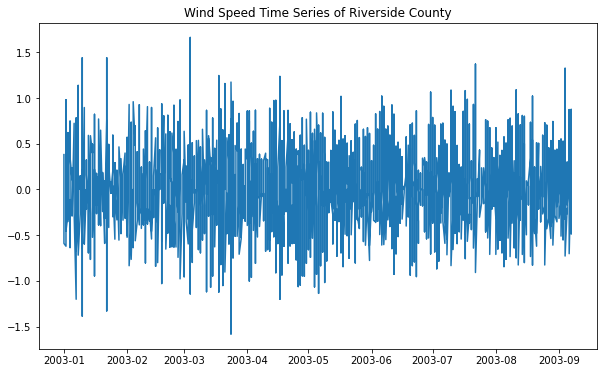

In [32]:
#Transformation
#Estimate of trend
river03_logScale = np.log(river03) #y values are changed
# plt.plot(river03_logScale) # ?

#Shift values to time series for forecasting y
datasetLogDiffShifting = river03_logScale - river03_logScale.shift()
plt.plot(datasetLogDiffShifting) #good improvement
plt.title("Wind Speed Time Series of Riverside County")

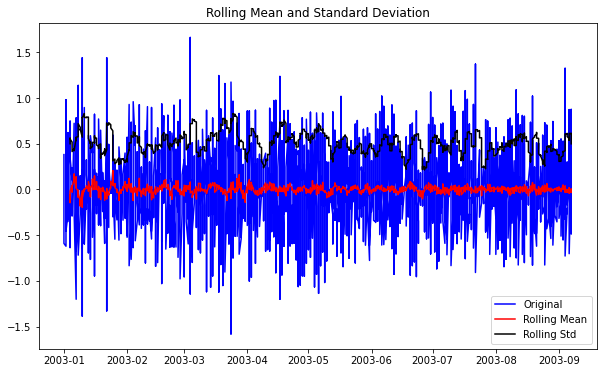

Result of Dickey-Fuller Test:
Test Statistic               -1.056019e+01
p-value                       7.764395e-19
#Lags Used                    2.200000e+01
Number of Observation Used    9.760000e+02
Critical Value (1%)          -3.437068e+00
Critical Value (5%)          -2.864506e+00
Critical Value (10%)         -2.568349e+00
dtype: float64


In [33]:
def test_stationarity(timeseries):
    #Determining rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Result of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['wind_speed'], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting) #shift by one


perfect data is stationary!

## <center> 5. Siskiyou County

In [34]:
siskiyou = pd.read_csv("/Users/selamawit/Desktop/STA160/Final/data/wind_data/Siskyou_county_wind_data.csv")
print(siskiyou.head())

         Date  wind_speed
0  2003-01-01         0.7
1  2003-01-01         4.5
2  2003-01-02         5.1
3  2003-01-02         9.8
4  2003-01-03         1.1


In [35]:
#Parse strings to datetime type
siskiyou['Date'] = pd.to_datetime(siskiyou['Date'], format='%Y-%m-%d')
siskiyou.index = siskiyou['Date']
del siskiyou['Date']

sis03 = siskiyou[siskiyou.index < "2003-12-30"]
print(sis03)

            wind_speed
Date                  
2003-01-01         0.7
2003-01-01         4.5
2003-01-02         5.1
2003-01-02         9.8
2003-01-03         1.1
...                ...
2003-12-27         2.9
2003-12-28         4.3
2003-12-28        10.3
2003-12-29         4.3
2003-12-29        18.3

[725 rows x 1 columns]


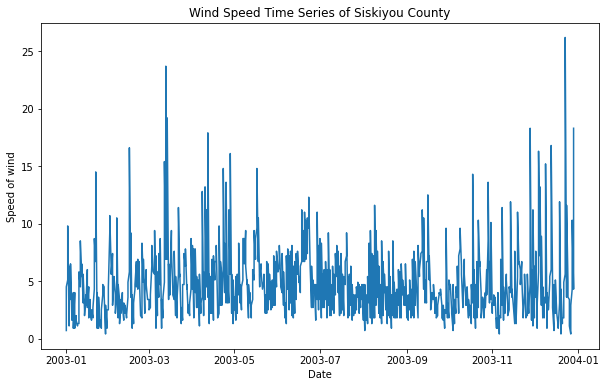

In [36]:
#plot
plt.xlabel("Date")
plt.ylabel("Speed of wind")
plt.title("Wind Speed Time Series of Siskiyou County")
plt.plot(sis03)

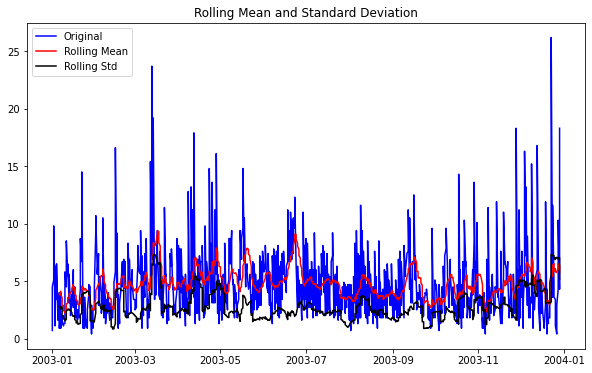

In [37]:
#Test stationarity of data:
#(1) Determining rolling statistics in annual level
rolmean = sis03.rolling(window=12).mean() #mean yearly level
rolstd = sis03.rolling(window=12).std()
# print(rolmean, rolstd)

#Plot rolling statistics
orig = plt.plot(sis03, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show(block=False)

In [38]:
#(2) Perform Dickey-Fuller test
print('Result of Dickey-Fuller test')
#AIC means and in time series
dftest = adfuller(sis03["wind_speed"], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key]=value
print(dfoutput)


Result of Dickey-Fuller test
Test Statistic                 -5.202443
p-value                         0.000009
#Lags Used                     17.000000
Number of Observation Used    707.000000
Critical Value (1%)            -3.439633
Critical Value (5%)            -2.865637
Critical Value (10%)           -2.568952
dtype: float64


not stationary!

Text(0.5, 1.0, 'Wind Speed Time Series of Siskiyou County')

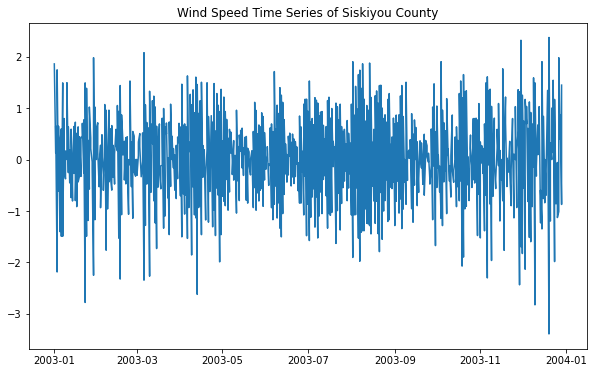

In [39]:
#Transformation
#Estimate of trend
sis03_logScale = np.log(sis03) #y values are changed
# plt.plot(sis03_logScale) #good improvement

#Shift values to time series for forecasting y
datasetLogDiffShifting = sis03_logScale - sis03_logScale.shift()
plt.plot(datasetLogDiffShifting) #great improvement
plt.title("Wind Speed Time Series of Siskiyou County")

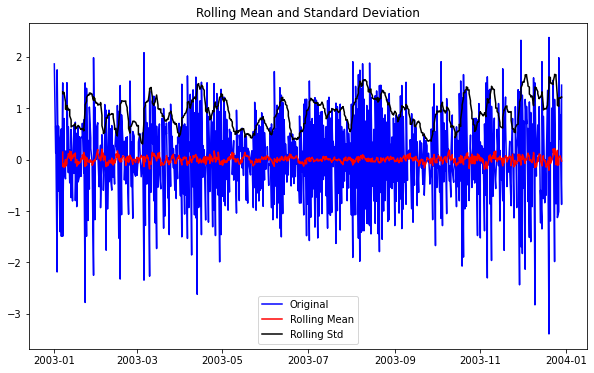

Result of Dickey-Fuller Test:
Test Statistic               -1.068253e+01
p-value                       3.907072e-19
#Lags Used                    1.800000e+01
Number of Observation Used    7.050000e+02
Critical Value (1%)          -3.439660e+00
Critical Value (5%)          -2.865648e+00
Critical Value (10%)         -2.568958e+00
dtype: float64


In [40]:
def test_stationarity(timeseries):
    #Determining rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Result of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['wind_speed'], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting) #shift by one

nice data is stationary!

## <center> 6. Merced County

In [41]:
merced = pd.read_csv("/Users/selamawit/Desktop/STA160/Final/data/wind_data/Merced_county_wind_data.csv")
print(merced.head())

         Date  wind_speed
0  2003-01-01         1.8
1  2003-01-02         3.6
2  2003-01-03         3.1
3  2003-01-04         2.5
4  2003-01-05         2.9


In [42]:
#Parse strings to datetime type
merced['Date'] = pd.to_datetime(merced['Date'], format='%Y-%m-%d')
merced.index = merced['Date']
del merced['Date']

mer03 = merced[merced.index < "2003-12-30"]
print(mer03)

            wind_speed
Date                  
2003-01-01         1.8
2003-01-02         3.6
2003-01-03         3.1
2003-01-04         2.5
2003-01-05         2.9
...                ...
2003-12-25         4.0
2003-12-26         1.6
2003-12-27         2.2
2003-12-28         4.7
2003-12-29        15.2

[363 rows x 1 columns]


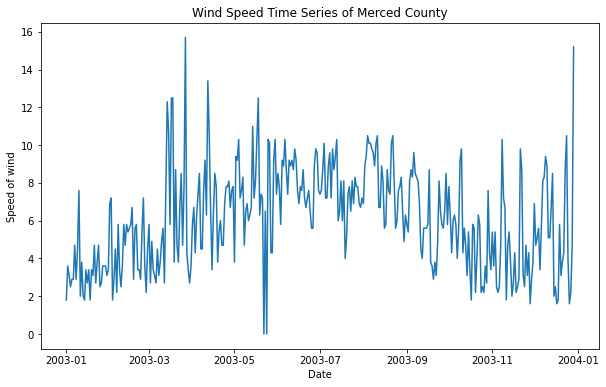

In [43]:
#plot
plt.xlabel("Date")
plt.ylabel("Speed of wind")
plt.title("Wind Speed Time Series of Merced County")
plt.plot(mer03)

In [44]:
#Test (2) to check stationarity of data == statistics of data
#(1) Determining rolling statistics in annual level
rolmean = mer03.rolling(window=12).mean()
rolstd = mer03.rolling(window=12).std()
# print(rolmean, rolstd)

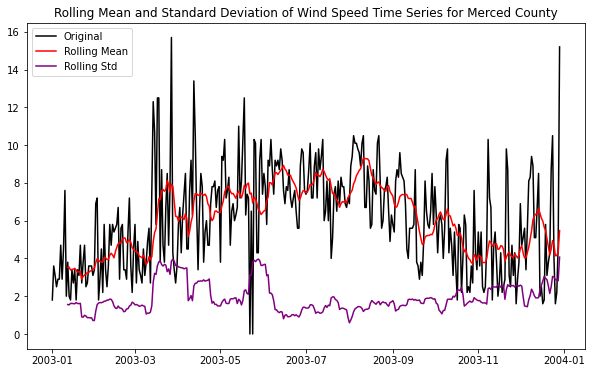

In [45]:
# Plot 
orig = plt.plot(mer03, color='black', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='purple', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation of Wind Speed Time Series for Merced County')
plt.show(block=False)

In [46]:
#(2) Perform Dickey-Fuller test
print('Result of Dickey-Fuller test')

#Akaike information criterion (AIC) 
dftest = adfuller(mer03["wind_speed"], autolag='AIC')
# print(dftest)
dfoutput = pd.Series(dftest[0:4], 
                     index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key]=value
print(dfoutput)

Result of Dickey-Fuller test
Test Statistic                 -3.359299
p-value                         0.012427
#Lags Used                      8.000000
Number of Observation Used    354.000000
Critical Value (1%)            -3.448958
Critical Value (5%)            -2.869739
Critical Value (10%)           -2.571138
dtype: float64


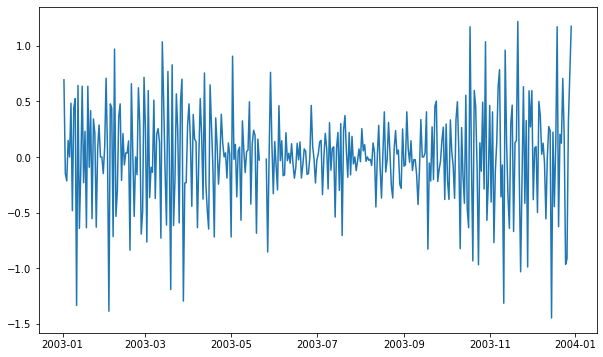

In [47]:
#Transformation
#Estimate of trend
mer03_logScale = np.log(mer03) #y values are changed
# plt.plot(mer03_logScale) #only little improvement

#Shift values to time series for forecasting y
datasetLogDiffShifting = mer03_logScale - mer03_logScale.shift()
plt.plot(datasetLogDiffShifting) #good improvement

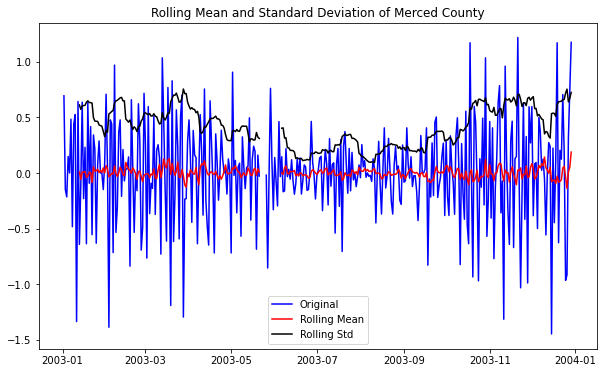

In [58]:
def test_stationarity(timeseries):
    #Determining rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation of Merced County')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
#     print('Result of Dickey-Fuller Test:')
#     dftest = adfuller(timeseries['wind_speed'], autolag='AIC')
#     dfoutput=pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation Used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print(dfoutput)

    
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting) #shift by one

In [49]:
#Take difference 
datasetLogScaleMinusMovingAverage = mer03_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove Nan Values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,wind_speed
Date,
2003-01-12,-2.298332
2003-01-13,-2.806853
2003-01-14,-3.212213
2003-01-15,-2.634558
2003-01-16,-2.765082
2003-01-17,-2.234558
2003-01-18,-2.812213
2003-01-19,-2.101225
2003-01-20,-2.193598


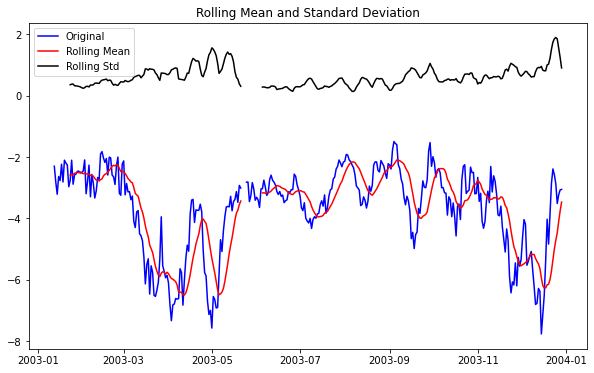

In [54]:
def test_stationarity(timeseries):
    #Determining rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
#     print('Result of Dickey-Fuller Test:')
#     dftest = adfuller(timeseries['wind_speed'], autolag='AIC')
#     dfoutput=pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation Used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print(dfoutput)

test_stationarity(datasetLogScaleMinusMovingAverage)

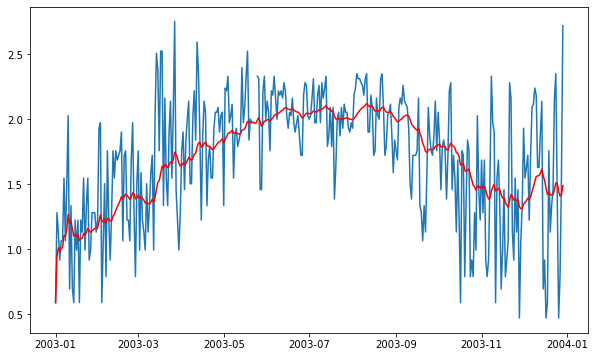

In [55]:
exponentialDecayWeightedAverage = mer03_logScale.ewm(halflife=12,min_periods=0,adjust=True).mean()
plt.plot(mer03_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

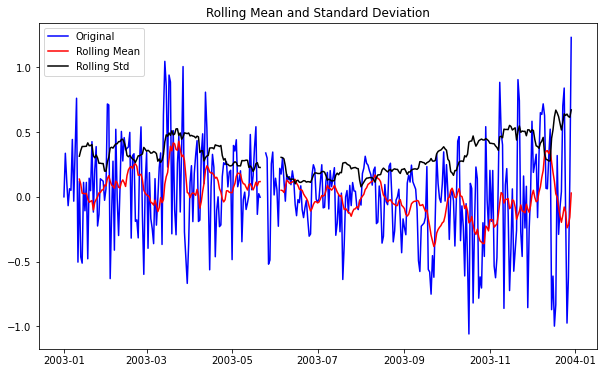

In [56]:
#Another Transformation
datasetScaleMinusMovingExponentialDecayAverage = mer03_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetScaleMinusMovingExponentialDecayAverage)

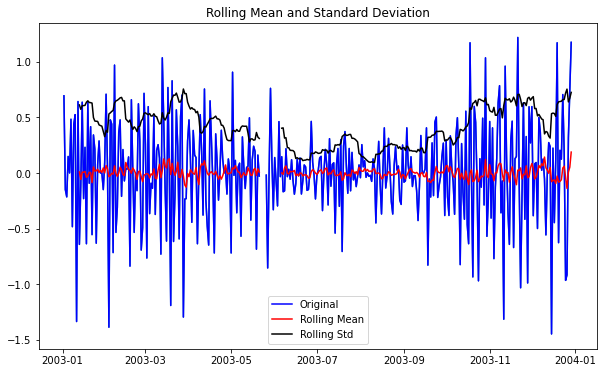

In [57]:
#Shift values to time series for forecasting y
datasetLogDiffShifting = mer03_logScale - mer03_logScale.shift()
plt.plot(datasetLogDiffShifting)
plt.title("Rolling Mean and Standard Deviation of Transformed Time Series for Merced County")

datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting) #shift by one